# Chapter 7: Utilizing Tools and Packages for Active ML

## Imports

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install modAL-python

In [16]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import numpy as np
import random
from modAL.models import ActiveLearner, Committee
from sklearn.ensemble import RandomForestClassifier
from modAL.uncertainty import uncertainty_sampling
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from modAL.disagreement import vote_entropy_sampling

## Customer Segmentation with KMeans in Scikit-learn

In [11]:
# Mock customer data (age, annual income)
X = np.array([[34, 20000], [42, 30000], [23, 25000], [32, 45000], [38, 30000]])

# Using KMeans for clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Predicting the cluster for each customer
clusters = kmeans.predict(X)

# Setting up a classifier
classifier = LogisticRegression()
classifier.fit(X, clusters)  # Training the classifier on our initial labeled data

# Simulating additional unlabeled data
X_unlabeled = np.array([[28, 22000], [45, 55000], [37, 35000], [50, 48000], [29, 27000], [41, 32000]])

# Function to obtain labels for selected instances
def obtain_labels(data):
    # This is a placeholder function. In a real scenario, we would obtain these labels through some form of data collection.
    # Here, we'll simulate this by randomly assigning one of the existing cluster labels.
    return np.random.choice([0, 1], size=len(data))

# Active Learning Loop
num_iterations = 10  # number of iterations
num_to_label = 2    # number of instances to label in each iteration

for iteration in range(num_iterations):
    if len(X_unlabeled) == 0:
        break  # No more data to label

    # Predict on unlabeled data
    predictions = classifier.predict_proba(X_unlabeled)
    uncertainty = np.max(predictions, axis=1)

    # Select num_to_label instances with least confidence
    uncertain_indices = np.argsort(uncertainty)[:num_to_label]

    # Obtain labels for these instances
    new_labels = obtain_labels(X_unlabeled[uncertain_indices])

    # Update our dataset
    X = np.vstack([X, X_unlabeled[uncertain_indices]])
    clusters = np.hstack([clusters, new_labels])

    # Re-train classifier and KMeans
    classifier.fit(X, clusters)
    kmeans.fit(X)

    print(f"Iteration {iteration+1}, Labeled Data: {X_unlabeled[uncertain_indices]} with Labels: {new_labels}")

    # Remove labeled instances from unlabeled data
    X_unlabeled = np.delete(X_unlabeled, uncertain_indices, axis=0)

    # Shuffle unlabeled data to avoid any order bias
    X_unlabeled = shuffle(X_unlabeled)


Iteration 1, Labeled Data: [[   45 55000]
 [   29 27000]] with Labels: [0 1]
Iteration 2, Labeled Data: [[   37 35000]
 [   28 22000]] with Labels: [1 1]
Iteration 3, Labeled Data: [[   41 32000]
 [   50 48000]] with Labels: [0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## modAL for Image Classification in Wildlife Monitoring

Download the Oregon Wildlife dataset from https://www.kaggle.com/datasets/virtualdvid/oregon-wildlife?resource=download
For this example, the dataset was stored in Google Drive.

In [52]:
!ls /content/drive/MyDrive/oregon_wildlife/oregon_wildlife

bald_eagle   columbian_black-tailed_deer  elk		   nutria   ringtail
black_bear   cougar			  gray_fox	   raccoon  sea_lions
bobcat	     coyote			  gray_wolf	   raven    seals
canada_lynx  deer			  mountain_beaver  red_fox  virginia_opossum


In [53]:
# Load the dataset
def load_images(directory, size=(224,224)):
    images = []
    labels = []
    for label_folder in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, label_folder)):
            for file in os.listdir(os.path.join(directory, label_folder)):
                file_path = os.path.join(directory, label_folder, file)
                image = Image.open(file_path).convert('L')  # convert to grayscale
                image = image.resize(size)
                images.append(np.array(image))
                labels.append(label_folder)  # or a numerical encoding of the label
    return np.array(images), np.array(labels)

# Path to the Oregon Wildlife dataset
data_path = '/content/drive/MyDrive/oregon_wildlife/oregon_wildlife'  # Replace with the actual path
X_all, y_all = load_images(data_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


bald_eagle


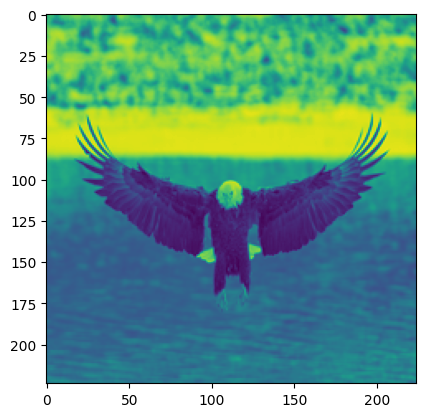

In [54]:
plt.imshow(X_all[0])
print(y_all[0])

In [55]:
# Split the dataset into initial labeled data and unlabeled data
X_initial, X_unlabeled, y_initial, _ = train_test_split(X_all, y_all, test_size=0.75, random_state=42)
print(f"We are starting our example with {len(X_initial)} labeled images and {len(X_unlabeled)} unlabeled images")

# Flatten the images for training
# To transform the image data into a format compatible with RandomForest, each image, which is a 2D array (or 3D for color images), is "flattened" into a 1D array.
# This means converting the image into a long vector of pixel values.
# For a grayscale image of size 224x224 pixels, the flattened form will be a vector of 50176 elements (224x224).
X_initial_flat = X_initial.reshape(len(X_initial), -1)

We are starting our example with 3503 labeled images and 10510 unlabeled images


In [49]:
# Initialize the learner
learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial_flat, y_training=y_initial
)

# Active learning loop
for i in range(10):
    query_idx, query_instance = learner.query(X_unlabeled.reshape(len(X_unlabeled), -1))
    # Here, you would obtain the label for the queried instance (e.g., via an oracle)
    # For now, we simulate obtaining the label
    label = np.random.choice(np.unique(y_all), 1)
    print(f"Selected unlabeled query is sample number {query_idx}. We simulate labeling this sample which is labeled as: {label}")
    learner.teach(X_unlabeled[query_idx].reshape(1, -1), label)
    X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)

Selected unlabeled query is sample number [369]. We simulate labeling this sample which is labeled as: ['raccoon']
Selected unlabeled query is sample number [81]. We simulate labeling this sample which is labeled as: ['raccoon']
Selected unlabeled query is sample number [78]. We simulate labeling this sample which is labeled as: ['virginia_opossum']
Selected unlabeled query is sample number [458]. We simulate labeling this sample which is labeled as: ['virginia_opossum']
Selected unlabeled query is sample number [33]. We simulate labeling this sample which is labeled as: ['raccoon']
Selected unlabeled query is sample number [28]. We simulate labeling this sample which is labeled as: ['raccoon']
Selected unlabeled query is sample number [87]. We simulate labeling this sample which is labeled as: ['raccoon']
Selected unlabeled query is sample number [23]. We simulate labeling this sample which is labeled as: ['raccoon']
Selected unlabeled query is sample number [231]. We simulate labelin

## modAL for QueryBy Committee on the Iris dataset

In [47]:
# Load the Iris dataset
X, y = load_iris(return_X_y=True)

In [48]:
# Initial split for labeled and unlabeled data
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.9, random_state=42)

In [50]:
# Create multiple learners for the committee
n_learners = 20
learners = [ActiveLearner(estimator=RandomForestClassifier(), X_training=X_labeled, y_training=y_labeled) for _ in range(n_learners)]

# Create the committee
committee = Committee(learner_list=learners, query_strategy=vote_entropy_sampling)

# Active learning loop
n_queries = 5
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_unlabeled)
    print(f"\nSelected unlabeled query is sample number {query_idx}. We simulate labeling this sample which is labeled as: {y_unlabeled[query_idx]}")
    committee.teach(X_unlabeled[query_idx], y_unlabeled[query_idx])

    # Remove the queried instance from the pool
    X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx)
    print(f"Number of unlabeled samples is {len(X_unlabeled)}")

    # Calculate and print committee score
    committee_score = committee.score(X, y)
    print(f"Iteration {idx+1}, Committee Score: {committee_score}")



Selected unlabeled query is sample number [8]. We simulate labeling this sample which is labeled as: [0]
Number of unlabeled samples is 129
Iteration 1, Committee Score: 0.96

Selected unlabeled query is sample number [125]. We simulate labeling this sample which is labeled as: [2]
Number of unlabeled samples is 128
Iteration 2, Committee Score: 0.9466666666666667

Selected unlabeled query is sample number [42]. We simulate labeling this sample which is labeled as: [2]
Number of unlabeled samples is 127
Iteration 3, Committee Score: 0.9466666666666667

Selected unlabeled query is sample number [47]. We simulate labeling this sample which is labeled as: [1]
Number of unlabeled samples is 126
Iteration 4, Committee Score: 0.9733333333333334

Selected unlabeled query is sample number [95]. We simulate labeling this sample which is labeled as: [1]
Number of unlabeled samples is 125
Iteration 5, Committee Score: 0.9733333333333334


In [51]:
# Final evaluation
final_score = committee.score(X, y)
print(f"Final Committee Score: {final_score}")

Final Committee Score: 0.9733333333333334
